# W205 Query Project: Assignment 05

Analysis of the publicly avalible Bay Area bikeshare data using Google's BigQuery. The objective of this assignment is to determine a promotion to increase ridership. See conclusion for reccomended promotion. Written by Andrew Walters (andrewfwalters@berkeley.edu).

## 0) Setup

** Imports **

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from mpl_toolkits.basemap import Basemap
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

** Useful Functions **

In [2]:
# create an executable shell command from array of sql sub strings
def bq_builder(strs,outfile,legacy_sql=True):
    
    # prefix
    query_str = "bq query"
    
    # legacy sql
    if(legacy_sql):
        query_str += " --use_legacy_sql=TRUE"
    else:
        query_str += " --use_legacy_sql=FALSE"
    
    # formatting
    query_str += " --format=csv"
    query_str += " --max_rows=10000"
    
    # sql string
    query_str += " \""
    for substr in strs:
        query_str += " "
        query_str += substr
    query_str += " \""
    
    # redirect ouptut
    query_str += " > "
    query_str += outfile
    
    # returns executable python
    return(query_str)

## 1) What are the 5 most common commuter trips?

** Exploratory Data Analysis **

Start by exploring the common weekday start times and whether there is any correlation with subscriptions.

In [3]:
q00_strs = ["SELECT HOUR(trips.start_date) AS start_hour,",
            "trips.subscriber_type,"
            "COUNT(trips.trip_id) AS num_trips",
            "FROM [bigquery-public-data:san_francisco.bikeshare_trips] AS trips",
            "WHERE DAYOFWEEK(trips.start_date) BETWEEN 2 AND 6",
            "GROUP BY start_hour, trips.subscriber_type",
            "ORDER BY start_hour, trips.subscriber_type ASC"]
q00_out = "q00.csv"
q00_cmd = bq_builder(q00_strs,outfile=q00_out,legacy_sql=True)
exit_stat = os.system(q00_cmd)

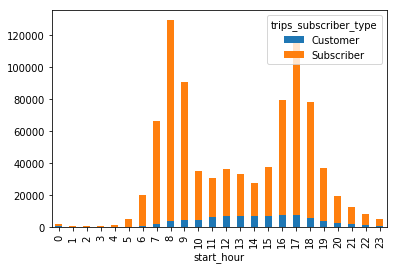

In [4]:
q00_res=pd.read_csv(q00_out)
q00_pivot = q00_res.pivot(index='start_hour', columns='trips_subscriber_type', values='num_trips')
q00_pivot.plot.bar(stacked=True);

The stacked bar graph above shows a surge in weekday traffic between 7am and 9am in the morning, and between 4pm and 6pm in the evening. Additionally we see that nearly all commuters are subscribers. We will exclude "Customers" from the following queries to find common commuter trips since the curve in the graph aboce indicates that most of them are not daily commuters.

** Query For Commutes **

Morning commute query

In [5]:
q01_strs = ["SELECT trips.start_station_id AS a_id,",
            "trips.start_station_name AS a_name,",
            "trips.end_station_id AS b_id,",
            "trips.end_station_name AS b_name,",
            "COUNT(trips.trip_id) AS num_trips",
            "FROM [bigquery-public-data:san_francisco.bikeshare_trips] AS trips",
            "WHERE DAYOFWEEK(trips.start_date) BETWEEN 2 AND 6 AND",
            "HOUR(trips.start_date) BETWEEN 7 AND 9",
            "AND trips.subscriber_type='Subscriber'"
            "GROUP BY a_id, a_name, b_id, b_name"]
q01_out = "q01.csv"
q01_cmd = bq_builder(q01_strs,outfile=q01_out,legacy_sql=True)
exit_stat = os.system(q01_cmd)
q01_res=pd.read_csv(q01_out)

Evening commute query

In [6]:
q02_strs = ["SELECT trips.start_station_id AS b_id,",
            "trips.start_station_name AS b_name,",
            "trips.end_station_id AS a_id,",
            "trips.end_station_name AS a_name,",
            "COUNT(trips.trip_id) AS num_trips",
            "FROM [bigquery-public-data:san_francisco.bikeshare_trips] AS trips",
            "WHERE DAYOFWEEK(trips.start_date) BETWEEN 2 AND 6 AND",
            "HOUR(trips.start_date) BETWEEN 16 AND 18",
            "AND trips.subscriber_type='Subscriber'"
            "GROUP BY a_id, a_name, b_id, b_name"]
q02_out = "q02.csv"
q02_cmd = bq_builder(q02_strs,outfile=q02_out,legacy_sql=True)
exit_stat = os.system(q02_cmd)
q02_res=pd.read_csv(q02_out)

Combine the results of the morning and evening commutes. Note that a and b are switched between starting and ending station. This assumes that a commuter travels from home to work in the morning, and takes the reverse trip in the evening.

In [7]:
commute_keys = ['a_id', 'a_name', 'b_id', 'b_name']
commutes = pd.concat([q01_res,q02_res])
commutes = commutes.groupby(commute_keys)['num_trips'].sum()
top_commutes = commutes.nlargest(25)
top_commutes = pd.DataFrame(top_commutes).reset_index()
commutes = pd.DataFrame(commutes).reset_index()

top_commutes.head(5)

,a_id,a_name,b_id,b_name,num_trips
0,50,Harry Bridges Plaza (Ferry Building),61,2nd at Townsend,8529
1,70,San Francisco Caltrain (Townsend at 4th),51,Embarcadero at Folsom,7308
2,74,Steuart at Market,60,Embarcadero at Sansome,6415
3,70,San Francisco Caltrain (Townsend at 4th),55,Temporary Transbay Terminal (Howard at Beale),6363
4,69,San Francisco Caltrain 2 (330 Townsend),65,Townsend at 7th,6207


** Visualize 25 Most Common Commutes on Map **

Get a local copy of stations table as dataframe

In [8]:
# get "a" station coordinates
q03_strs = ["SELECT station_id, latitude, longitude",
            "FROM [bigquery-public-data:san_francisco.bikeshare_stations];"]
q03_out = "q03.csv"
q03_cmd = bq_builder(q03_strs,outfile=q03_out,legacy_sql=True)
exit_stat = os.system(q03_cmd)

In [9]:
q03_res=pd.read_csv(q03_out)

Join "A" station coordinates with table followed by "B" station coordinates.

In [10]:
top_commutes = pd.merge(top_commutes,
                        q03_res,
                        how='left',
                        left_on='a_id',
                        right_on='station_id')
top_commutes = top_commutes.rename(columns={"latitude": "a_lat", "longitude": "a_lon"})
top_commutes = top_commutes.drop("station_id",axis=1)

In [11]:
top_commutes = pd.merge(top_commutes,
                        q03_res,
                        how='left',
                        left_on='b_id',
                        right_on='station_id')
top_commutes = top_commutes.rename(columns={"latitude": "b_lat", "longitude": "b_lon"})
top_commutes = top_commutes.drop("station_id",axis=1)

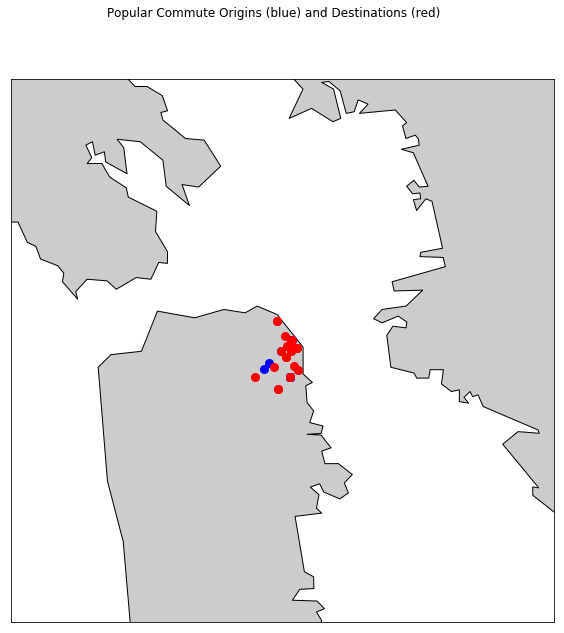

In [49]:
# first define a transverse mercator projection centered on the bay area
map_width_m = 30 * 1000
map_height_m = 30 * 1000
fig_width = 10
fig = plt.figure(figsize=[fig_width, fig_width * map_height_m / float(map_width_m)])
m = Basemap(ellps='WGS84',
            projection='tmerc',
            lon_0=-122.4, 
            lat_0=37.79,
            width=map_width_m, 
            height=map_height_m,
            resolution='h',
            area_thresh=10)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents()

# plot a stations
a_lon = list(top_commutes['a_lon'])
a_lat = list(top_commutes['a_lat'])
x,y = m(a_lon, a_lat)
m.plot(x, y, 'bo', markersize=8)

# plot b stations
b_lon = list(top_commutes['b_lon'])
b_lat = list(top_commutes['b_lat'])
x,y = m(b_lon, b_lat)
m.plot(x, y, 'ro', markersize=8)

plt.suptitle("Popular Commute Origins (blue) and Destinations (red)")
plt.show()

The remarkable aspect of this visualization is the concentration of commutes. Even though the bikeshare program covers the entire bay area, only a small section in Downtonw San Francisco contains popular commute routes. Additionally of the 25 most popular routes, many share the same stations (red destination points were plotted second and therefore cover some blue origin stations). The take away is that commute volume is driven by population density.

## 2) How do commuters compare in volume to other riders

In [13]:
# count all trips in the trips table
q04_strs = ["SELECT COUNT(trips.trip_id)",
            "FROM [bigquery-public-data:san_francisco.bikeshare_trips] AS trips"]
q04_out = "q04.csv"
q04_cmd = bq_builder(q04_strs,outfile=q04_out,legacy_sql=True)
exit_stat = os.system(q04_cmd)
q04_res=pd.read_csv(q04_out)

In [14]:
# display breakdown of commutes to other trips
count_commutes = q01_res["num_trips"].sum() + q02_res["num_trips"].sum()
count_trips = q04_res["f0_"][0]
pd.DataFrame({"Total Trips":[count_trips],"Total Commutes":[count_commutes],"Proportion Commutes":[count_commutes/count_trips]})

,Proportion Commutes,Total Commutes,Total Trips
0,0.538679,529871,983648


Given the conservative classification of commutes (only included subscribers' trips in a 3 hour morning and evening window), 53% is a high amount of volume. There are likely more commuters working off shifts, so we can safely conclude that commuting is the dominant use case for the bike share.

## 3) How does trip duration vary by time of day

Query weekday travel volume and duration, followed by weekends.

In [16]:
q06_strs = ["SELECT AVG(TIMESTAMP_DIFF(trips.end_date,trips.start_date,MINUTE)) AS diff_avg,",
            "COUNT(trips.trip_id) AS num_trips,",
            "EXTRACT(HOUR FROM trips.start_date) AS start_hour",
            "FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS trips",
            "WHERE EXTRACT(DAYOFWEEK FROM trips.start_date) BETWEEN 2 AND 6",
            "GROUP BY start_hour",
            "ORDER BY start_hour ASC;"]
q06_out = "q06.csv"
q06_cmd = bq_builder(q06_strs,outfile=q06_out,legacy_sql=True)
#exit_stat = os.system(q06_cmd)

In [17]:
q07_strs = ["SELECT AVG(TIMESTAMP_DIFF(trips.end_date,trips.start_date,MINUTE)) AS diff_avg,",
            "COUNT(trips.trip_id) AS num_trips,",
            "EXTRACT(HOUR FROM trips.start_date) AS start_hour",
            "FROM `bigquery-public-data.san_francisco.bikeshare_trips` AS trips",
            "WHERE ( EXTRACT(DAYOFWEEK FROM trips.start_date)=1 OR EXTRACT(DAYOFWEEK FROM trips.start_date)=7 )",
            "GROUP BY start_hour",
            "ORDER BY start_hour ASC;"]
q07_out = "q07.csv"
q07_cmd = bq_builder(q07_strs,outfile=q07_out,legacy_sql=False)
#exit_stat = os.system(q07_cmd)

In [23]:
q06_res=pd.read_csv(q06_out)
q06_res = q06_res.set_index(keys=['start_hour'])
q07_res=pd.read_csv(q07_out)
q07_res = q07_res.set_index(keys=['start_hour'])

Text(0.5,1,'Weekday Volume')

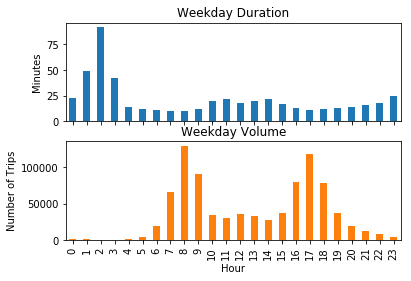

In [25]:
# weekday plot
ax = q06_res.plot(kind="bar",subplots=True,legend=None);
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Minutes")
ax[0].set_title("Weekday Duration")
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Number of Trips")
ax[1].set_title("Weekday Volume")

Text(0.5,1,'Weekend Volume')

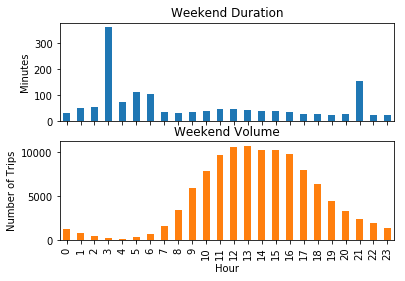

In [26]:
# weekend plot
ax = q07_res.plot(kind="bar",subplots=True,legend=None);
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Minutes")
ax[0].set_title("Weekend Duration")
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Number of Trips")
ax[1].set_title("Weekend Volume")

Weekend trip durations are much longer than a typical workday (around 10 minutes), which indicates a much larger number of weekend users are leisure users. High early morning trip durations and low ridership indicates a very small exercise user base exists.

## 4) Are there any imbalances of bikes that need to be noted

** Query For Stations That Are Frequently Empty Or Full **

In [36]:
# count all trips in the trips table
q08_strs = ["SELECT COUNT(status.bikes_available) AS no_bikes,",
            "station.name,",
            "status.station_id,",
            "station.latitude,",
            "station.longitude",
            "FROM [bigquery-public-data:san_francisco.bikeshare_status] AS status",
            "LEFT JOIN [bigquery-public-data:san_francisco.bikeshare_stations] AS station",
            "ON status.station_id = station.station_id",
            "WHERE status.bikes_available=0",
            "GROUP BY station.name, status.station_id, station.latitude, station.longitude",
            "ORDER BY no_bikes DESC",
            "LIMIT 10;"]
q08_out = "q08.csv"
q08_cmd = bq_builder(q08_strs,outfile=q08_out,legacy_sql=True)
exit_stat = os.system(q08_cmd)

In [43]:
# count all trips in the trips table
q09_strs = ["SELECT COUNT(status.bikes_available) AS full_bikes,",
            "station.name,",
            "status.station_id,",
            "station.latitude,",
            "station.longitude",
            "FROM [bigquery-public-data:san_francisco.bikeshare_status] AS status",
            "LEFT JOIN [bigquery-public-data:san_francisco.bikeshare_stations] AS station",
            "ON status.station_id = station.station_id",
            "WHERE status.bikes_available=station.dockcount",
            "GROUP BY station.name, status.station_id, station.latitude, station.longitude",
            "ORDER BY full_bikes DESC",
            "LIMIT 10;"]
q09_out = "q09.csv"
q09_cmd = bq_builder(q09_strs,outfile=q09_out,legacy_sql=True)
exit_stat = os.system(q09_cmd)

In [44]:
q08_res=pd.read_csv(q08_out)
q09_res=pd.read_csv(q09_out)

,full_bikes,station_name,status_station_id,station_latitude,station_longitude
0,39801,San Francisco Caltrain (Townsend at 4th),70,37.776617,-122.395260
1,38400,Embarcadero at Bryant,54,37.787152,-122.388013
2,23932,Embarcadero at Sansome,60,37.804770,-122.403234
3,22086,San Francisco Caltrain 2 (330 Townsend),69,37.776600,-122.395470
4,16528,Civic Center BART (7th at Market),72,37.781039,-122.411748
5,16508,Townsend at 7th,65,37.771058,-122.402717
6,16065,Embarcadero at Vallejo,48,37.799953,-122.398525
7,15274,Harry Bridges Plaza (Ferry Building),50,37.795392,-122.394203
8,13498,Powell Street BART,39,37.783871,-122.408433
9,12153,Santa Clara at Almaden,4,37.333988,-121.894902


** Visualize Problematic Stations **

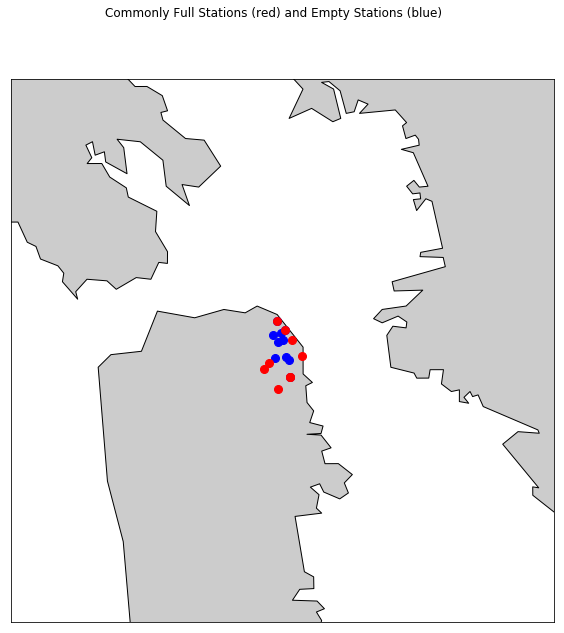

In [48]:
# first define a transverse mercator projection centered on the bay area
map_width_m = 30 * 1000
map_height_m = 30 * 1000
fig_width = 10
fig = plt.figure(figsize=[fig_width, fig_width * map_height_m / float(map_width_m)])
m = Basemap(ellps='WGS84',
            projection='tmerc',
            lon_0=-122.4, 
            lat_0=37.79,
            width=map_width_m, 
            height=map_height_m,
            resolution='h',
            area_thresh=10)

m.drawcoastlines()
m.drawcountries()
m.fillcontinents()

# plot a stations
a_lon = list(q08_res['station_longitude'])
a_lat = list(q08_res['station_latitude'])
x,y = m(a_lon, a_lat)
m.plot(x, y, 'bo', markersize=8)

# plot b stations
b_lon = list(q09_res['station_longitude'])
b_lat = list(q09_res['station_latitude'])
x,y = m(b_lon, b_lat)
m.plot(x, y, 'ro', markersize=8)

plt.suptitle("Commonly Full Stations (red) and Empty Stations (blue)")
plt.show()

Similarly to commuting patterns, the stations that are most often out of or overstocked with bikes are in Downtown San Francisco. This informs us that the downtown market may already be saturated with users, and short of building more docks there is not much we can do to increase ridership.

## 5) Conclusion


The promotion that we offer should encourage commuting, since commuters are the largest group of current users. They are more likely to be repeat users, given how many of them are subscribers. Additionally they live in the city and are more likely to see marketing related to a discount. The issue is that the current population of commuters has already saturated the downtown market, and there are often shortages of bikes or nowhere to dock a bike. This means that we should target commuters in less traditional biking areas.

It is my reccomendation that we offer a day pass that allows unlimited 30-minute rides. This will encourage people in the bay area that previously had not considered bike commuting to give it a try. The hope is that some of these new users will decide to start bike commuting on a regular basis and create an ongoing revenue stream. One potential concern is that commuters outside of downtown San Francisco are likely going to have longer commutes in the more suburban communities of East Bay, Silicon Valley, and San Jose. A typical city commute is between 10 and 20 minutes so there is a risk that the 30 minute promotion doesn't encourage ridership outside of the main population centers.